In [0]:
# Source : https://github.com/tdeboissiere/DeepLearningImplementations/tree/master/GAN 
# Project Title : Convert GAN implementation into IPython Notebook

# Current 
# 1. Convert main model,training files
# 2. Create HDF5 dataset to be used for training
# 3. Trained network on CelebA dataset for 400 epochs
# 4. Improve implementation to generate better quality images using other GAN implementations like BEGAN, PGGAN etc. (WIP)
# 5. Add descriptions in code (WIP)

#Improvements from last time
# 1. More understanding of code, better documentation
# 1. Tried running BEGAN (Need to integrate)
# 2. Took a shot at PGGAN implementation (Trying to port from Pytorch to KERAS)

#Final expectation
# 1. Atleast implement BEGAN
# 2. Implement WGAN optimizations
# 3. Try and implement PGGAN

In [0]:
!git clone https://github.com/siddharthalodha/DCGAN_KERAS.git
!cp -r DCGAN_KERAS/models .
!cp -r DCGAN_KERAS/figures .
!cp -r DCGAN_KERAS/utils .  

# Download CelebA dataset from Google drive

In [0]:
#Code to download CelebA hdf5 dataset from google drive
!pip install PyDrive

from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileId = drive.CreateFile({'id': '1cUBPxqU-9Y6f_OAfPwdRmPg7ruZ2sfdk'})
print(fileId['title'])  # CelebA Dataset
fileId.GetContentFile('CelebA_64_data.h5')  # Save Drive file as a local file

# Import libraries

In [0]:
!pip install -q keras
import keras

#Fixing graphviz pydot installation for plot_model function to work
#!sudo apt-get install graphviz
#!pip install pydot
#!pip install graphviz
#!pip install graphviz pydot

!apt-get -qq install -y graphviz && pip install -q pydot

In [0]:
#import graphviz
import pydot
import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot')
%matplotlib inline

In [0]:
import os
import sys
import time

import keras.backend as K

import tensorflow as tf

from keras.models import Model
from keras.layers.core import Flatten, Dense, Dropout, Activation, Lambda, Reshape
from keras.layers.convolutional import Conv2D, Deconv2D, ZeroPadding2D, UpSampling2D
from keras.layers import Input, Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization

from keras.utils import generic_utils
from keras.optimizers import Adam, SGD
from keras.utils import plot_model
from keras.utils.generic_utils import Progbar

from IPython.core.debugger import set_trace

sys.path.append("./utils") # Utils
import general_utils
import data_utils #Being used for importing data,generating batches (CelebA Data is currently stored in an hdf5 file)
%matplotlib inline

#!mkdir /figures

** Check the Version of TensorFlow and Access to GPU **

In [49]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
      raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

Found GPU at: /device:GPU:0


# Define Hyperparameters

In [0]:
#Hyperparameters

backend="tensorflow" #Specify backend to be used
dset="celebA" #Specify dataset to be used, currently supported : mnist/celebA
generator="upsampling" #Generator to be used : upsampling/deconv
model_name="CNN" #Name of model
batch_size=32 #Batch size to be used 
n_batch_per_epoch=200 #Number of batches per epoch
nb_epoch=400 #Number of epochs
epoch=10 #Epoch size => Used for progress bars 
nb_classes=2 #Number of classes
do_plot=True #Plotting during execution
bn_mode=2 #Batch normalization
img_dim=64 #Dimension of image
label_smoothing="store_true" #Label smoothing
label_flipping=0 #Label flipping
noise_scale=0.5 
use_mbd="store_true"
image_data_format = "channels_last"

#  Define generator function#1 : Upsampling

Preferable for CelebA dataset

In [0]:
def generator_upsampling(noise_dim, img_dim, bn_mode, model_name="generator_upsampling", dset="celebA"):
    """
    Generator model of the DCGAN
    args : img_dim (tuple of int) num_chan, height, width
           pretr_weights_file (str) file holding pre trained weights
    returns : model (keras NN) the Neural Net model
    """

    s = img_dim[1]
    f = 512

    if dset == "mnist":
        start_dim = int(s / 4)
        nb_upconv = 2
    else:
        start_dim = int(s / 16)
        nb_upconv = 4

    if K.image_data_format() == "channels_first":
        bn_axis = 1
        reshape_shape = (f, start_dim, start_dim)
        output_channels = img_dim[0]
    else:
        reshape_shape = (start_dim, start_dim, f)
        bn_axis = -1
        output_channels = img_dim[-1]

    gen_input = Input(shape=noise_dim, name="generator_input")

    x = Dense(f * start_dim * start_dim, input_dim=noise_dim)(gen_input)
    x = Reshape(reshape_shape)(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)

    # Upscaling blocks
    for i in range(nb_upconv):
        x = UpSampling2D(size=(2, 2))(x)
        nb_filters = int(f / (2 ** (i + 1)))
        x = Conv2D(nb_filters, (3, 3), padding="same")(x)
        x = BatchNormalization(axis=1)(x)
        x = Activation("relu")(x)
        x = Conv2D(nb_filters, (3, 3), padding="same")(x)
        x = Activation("relu")(x)

    x = Conv2D(output_channels, (3, 3), name="gen_Conv2D_final", padding="same", activation='tanh')(x)

    generator_model = Model(inputs=[gen_input], outputs=[x], name=model_name)

    return generator_model

# Define generator function#2 : Deconvolution

Preferable for MNIST dataset

In [0]:
def generator_deconv(noise_dim, img_dim, bn_mode, batch_size, model_name="generator_deconv", dset="mnist"):
    """
    Generator model of the DCGAN
    args : nb_classes (int) number of classes
           img_dim (tuple of int) num_chan, height, width
           pretr_weights_file (str) file holding pre trained weights
    returns : model (keras NN) the Neural Net model
    """

    assert K.backend() == "tensorflow", "Deconv not implemented with theano"

    s = img_dim[1]
    f = 512

    if dset == "mnist":
        start_dim = int(s / 4)
        nb_upconv = 2
    else:
        start_dim = int(s / 16)
        nb_upconv = 4

    reshape_shape = (start_dim, start_dim, f)
    bn_axis = -1
    output_channels = img_dim[-1]

    gen_input = Input(shape=noise_dim, name="generator_input")

    x = Dense(f * start_dim * start_dim, input_dim=noise_dim)(gen_input)
    x = Reshape(reshape_shape)(x)
    x = BatchNormalization(axis=bn_axis)(x)
    x = Activation("relu")(x)

    # Transposed conv blocks
    for i in range(nb_upconv - 1):
        nb_filters = int(f / (2 ** (i + 1)))
        s = start_dim * (2 ** (i + 1))
        o_shape = (batch_size, s, s, nb_filters)
        x = Deconv2D(nb_filters, (3, 3), output_shape=o_shape, strides=(2, 2), padding="same")(x)
        x = BatchNormalization(axis=-1)(x)
        x = Activation("relu")(x)

    # Last block
    s = start_dim * (2 ** (nb_upconv))
    o_shape = (batch_size, s, s, output_channels)
    x = Deconv2D(output_channels, (3, 3), output_shape=o_shape, strides=(2, 2), padding="same")(x)
    x = Activation("tanh")(x)

    generator_model = Model(inputs=[gen_input], outputs=[x], name=model_name)

    return generator_model

# Define discriminator function

Implement discriminator to create a discriminator neural network that discriminates on images. 


In [0]:
def DCGAN(generator, discriminator_model, noise_dim, img_dim):

    noise_input = Input(shape=noise_dim, name="noise_input")

    generated_image = generator(noise_input)
    DCGAN_output = discriminator_model(generated_image)

    DCGAN = Model(inputs=[noise_input],
                  outputs=[DCGAN_output],
                  name="DCGAN")
    return DCGAN

In [0]:
def DCGAN_discriminator(noise_dim, img_dim, bn_mode, model_name="DCGAN_discriminator", dset="celebA", use_mbd=False):
    """
    Discriminator model of the DCGAN
    args : img_dim (tuple of int) num_chan, height, width
           pretr_weights_file (str) file holding pre trained weights
    returns : model (keras NN) the Neural Net model
    """
    #Image data format : channels_first for theano backend and channels_last for tensorflow backend
    if K.image_data_format() == "channels_first":
        bn_axis = 1
    else:
        bn_axis = -1

    disc_input = Input(shape=img_dim, name="discriminator_input")

    if dset == "mnist":
        list_f = [128]

    else:
        list_f = [64, 128, 256]

    # First conv
    x = Conv2D(32, (3, 3), strides=(2, 2), name="disc_Conv2D_1", padding="same")(disc_input)
    x = BatchNormalization(axis=bn_axis)(x)
    x = LeakyReLU(0.2)(x)

    # Next convs
    for i, f in enumerate(list_f):
        name = "disc_Conv2D_%s" % (i + 2)
        x = Conv2D(f, (3, 3), strides=(2, 2), name=name, padding="same")(x)
        x = BatchNormalization(axis=bn_axis)(x)
        x = LeakyReLU(0.2)(x)

    x = Flatten()(x)

    def minb_disc(x):
        diffs = K.expand_dims(x, 3) - K.expand_dims(K.permute_dimensions(x, [1, 2, 0]), 0)
        abs_diffs = K.sum(K.abs(diffs), 2)
        x = K.sum(K.exp(-abs_diffs), 2)

        return x

    def lambda_output(input_shape):
        return input_shape[:2]

    num_kernels = 100
    dim_per_kernel = 5

    M = Dense(num_kernels * dim_per_kernel, use_bias=False, activation=None)
    MBD = Lambda(minb_disc, output_shape=lambda_output)

    if use_mbd:
        x_mbd = M(x)
        x_mbd = Reshape((num_kernels, dim_per_kernel))(x_mbd)
        x_mbd = MBD(x_mbd)
        x = Concatenate(axis=bn_axis)([x, x_mbd])

    x = Dense(2, activation='softmax', name="disc_dense_2")(x)

    discriminator_model = Model(inputs=[disc_input], outputs=[x], name=model_name)

    return discriminator_model

# Define model loader

Implement loader to load specific models : 
1. Generators : Upsampling, Deconvolution
2. Discriminator : DCGAN


In [0]:
def load(model_name, noise_dim, img_dim, bn_mode, batch_size, dset="mnist", use_mbd=False):

    if model_name == "generator_upsampling":
        model = generator_upsampling(noise_dim, img_dim, bn_mode, model_name=model_name, dset=dset)
        model.summary()
        plot_model(model, to_file='./figures/%s.png' % model_name, show_shapes=True, show_layer_names=True)
        return model
    if model_name == "generator_deconv":
        model = generator_deconv(noise_dim, img_dim, bn_mode, batch_size, model_name=model_name, dset=dset)
        model.summary()
        plot_model(model, to_file='./figures/%s.png' % model_name, show_shapes=True, show_layer_names=True)
        return model
    if model_name == "DCGAN_discriminator":
        model = DCGAN_discriminator(noise_dim, img_dim, bn_mode, model_name=model_name, dset=dset, use_mbd=use_mbd)
        model.summary()
        plot_model(model, to_file='./figures/%s.png' % model_name, show_shapes=True, show_layer_names=True)
        return model

In [0]:
def show_image():
#Display final image
  %matplotlib inline
  import matplotlib.pyplot as plt
  import matplotlib.image as mpimg
  from scipy import ndimage, misc
  
  img=mpimg.imread('./figures/current_batch.png')
  imgplot = plt.imshow(img)
  plt.show()
  return

# Train the network

> **Optimizer used** : 

>> DCGAN : Adam with LR .0002

>> Discriminator : SGD with momentum and LR 0.001







In [0]:
def train_GAN(batch_size,n_batch_per_epoch,nb_epoch,generator,model_name,image_data_format,img_dim,bn_mode,label_smoothing,label_flipping,noise_scale,dset,use_mbd,epoch_size):
    # Setup environment (logging directory etc)
    general_utils.setup_logging(model_name)

    # Load and rescale data
    if dset == "celebA":
        X_real_train = data_utils.load_celebA(img_dim, image_data_format)
    if dset == "mnist":
        X_real_train, _, _, _ = data_utils.load_mnist(image_data_format)
    img_dim = X_real_train.shape[-3:]
    noise_dim = (100,)
    
    try:

        # Create optimizers
        opt_dcgan = Adam(lr=2E-4, beta_1=0.5, beta_2=0.999, epsilon=1e-08)
        opt_discriminator = SGD(lr=1E-3, momentum=0.9, nesterov=True)

        # Load generator model
        generator_model = load("generator_%s" % generator,
                                      noise_dim,
                                      img_dim,
                                      bn_mode,
                                      batch_size,
                                      dset=dset,
                                      use_mbd=use_mbd)
        
        # Load discriminator model
        discriminator_model = load("DCGAN_discriminator",
                                          noise_dim,
                                          img_dim,
                                          bn_mode,
                                          batch_size,
                                          dset=dset,
                                          use_mbd=use_mbd)

        generator_model.compile(loss='mse', optimizer=opt_discriminator)
        discriminator_model.trainable = False
        DCGAN_model = DCGAN(generator_model,
                                   discriminator_model,
                                   noise_dim,
                                   img_dim)
        
        loss = ['binary_crossentropy']
        loss_weights = [1]
        DCGAN_model.compile(loss=loss, loss_weights=loss_weights, optimizer=opt_dcgan) #Compile DCGAN model with optimizer as adam

        discriminator_model.trainable = True
        discriminator_model.compile(loss='binary_crossentropy', optimizer=opt_discriminator)

        #Initiliaze generator and discriminator loss
        gen_loss = 100
        disc_loss = 100

        # Start training for epochs=nb_epoch 
        print("Start training")
        for e in range(nb_epoch):
            #Initialize progbar and batch counter
            #progbar = Progbar(epoch_size) #Check Progbar logic also before, tensorboard implementation
            batch_counter = 1
            start = time.time()
            for X_real_batch in data_utils.gen_batch(X_real_train, batch_size):

                # Create a batch to feed the discriminator model
                X_disc, y_disc = data_utils.get_disc_batch(X_real_batch,
                                                           generator_model,
                                                           batch_counter,
                                                           batch_size,
                                                           noise_dim,
                                                           noise_scale=noise_scale,
                                                           label_smoothing=label_smoothing,
                                                           label_flipping=label_flipping)

                # Update the discriminator
                #train_on_batch is used for training instead of the traditional model.fit because we need to update existing trained model on new batch.
                #train_on_batch is for updating a pre-trained model on a single new batch of samples
                disc_loss = discriminator_model.train_on_batch(X_disc, y_disc)

                # Create a batch to feed the generator model
                X_gen, y_gen = data_utils.get_gen_batch(batch_size, noise_dim, noise_scale=noise_scale)

                # Freeze the discriminator
                discriminator_model.trainable = False
                gen_loss = DCGAN_model.train_on_batch(X_gen, y_gen)
                # Unfreeze the discriminator
                discriminator_model.trainable = True

                batch_counter += 1
                #progbar.add(batch_size, values=[("D logloss", disc_loss),
                #                                ("G logloss", gen_loss)])

                 #Save images for visualization
                if batch_counter % 100 == 0:
                    data_utils.plot_generated_batch(X_real_batch, generator_model,
                                                    batch_size, noise_dim, image_data_format)
                    
                if batch_counter >= n_batch_per_epoch:
                    break

            print("")
            print('Epoch %s/%s, Time: %s, Discriminator loss:%s,Generator loss:%s' % (e + 1, nb_epoch, time.time() - start,disc_loss,gen_loss))
            show_image()

            #Save weights for generator,discriminator and DCGAN
            if e % 5 == 0:
                gen_weights_path = os.path.join('./models/%s/gen_weights_epoch%s.h5' % (model_name, e))
                generator_model.save_weights(gen_weights_path, overwrite=True)

                disc_weights_path = os.path.join('./models/%s/disc_weights_epoch%s.h5' % (model_name, e))
                discriminator_model.save_weights(disc_weights_path, overwrite=True)

                DCGAN_weights_path = os.path.join('./models/%s/DCGAN_weights_epoch%s.h5' % (model_name, e))
                DCGAN_model.save_weights(DCGAN_weights_path, overwrite=True)
    except Exception as e:
            print(e)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator_input (InputLayer) (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 8192)              827392    
_________________________________________________________________
reshape_7 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 4, 4, 512)         2048      
_________________________________________________________________
activation_28 (Activation)   (None, 4, 4, 512)         0         
_________________________________________________________________
up_sampling2d_13 (UpSampling (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 8, 8, 256)         1179904   
__________

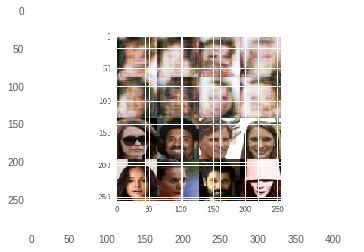


Epoch 2/400, Time: 25.509984254837036, Discriminator loss:0.91260254,Generator loss:2.9872928


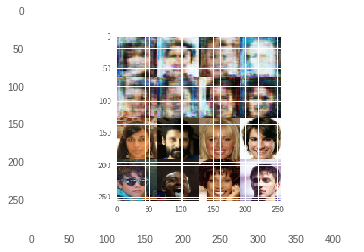


Epoch 3/400, Time: 25.383503198623657, Discriminator loss:0.87109315,Generator loss:1.7578435


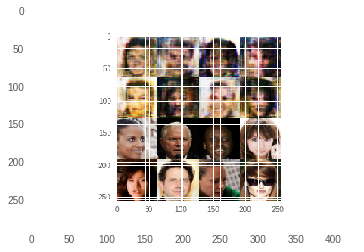


Epoch 4/400, Time: 25.29926061630249, Discriminator loss:0.8612969,Generator loss:1.9512833


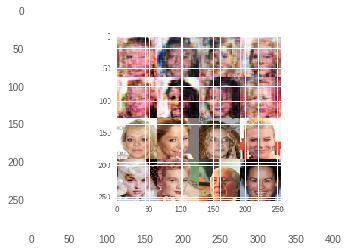


Epoch 5/400, Time: 25.342130422592163, Discriminator loss:0.895788,Generator loss:2.599031


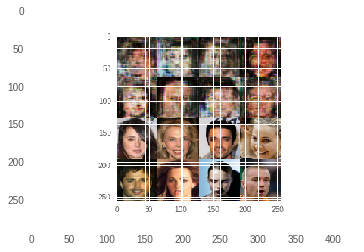


Epoch 6/400, Time: 25.274052143096924, Discriminator loss:0.7980876,Generator loss:2.5425758


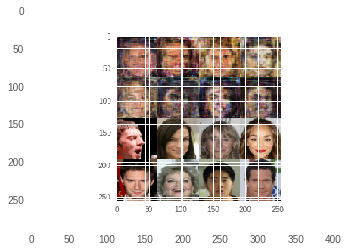


Epoch 7/400, Time: 25.31103277206421, Discriminator loss:0.7860193,Generator loss:2.2221127


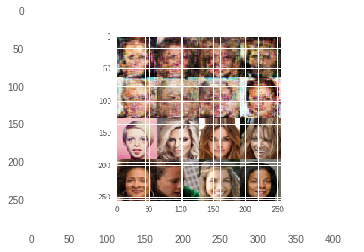


Epoch 8/400, Time: 25.333345651626587, Discriminator loss:0.91008765,Generator loss:2.1877174


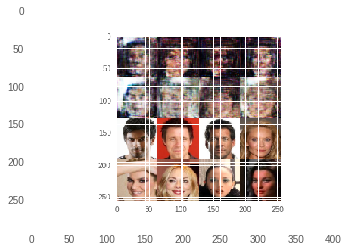


Epoch 9/400, Time: 25.352949380874634, Discriminator loss:0.788689,Generator loss:2.985701


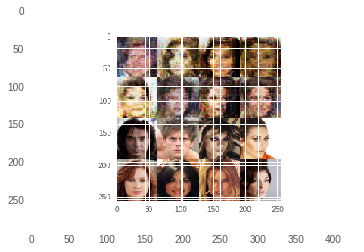


Epoch 10/400, Time: 25.332391023635864, Discriminator loss:1.1953135,Generator loss:2.141388


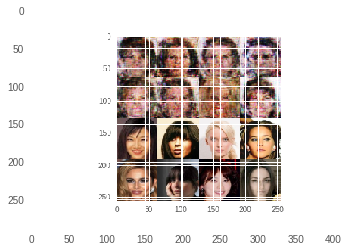


Epoch 11/400, Time: 25.27807378768921, Discriminator loss:0.78022826,Generator loss:2.3795483


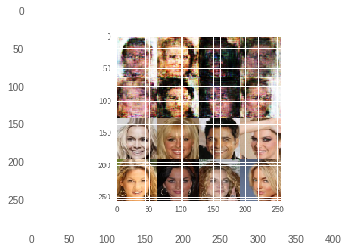


Epoch 12/400, Time: 25.20694851875305, Discriminator loss:0.7628232,Generator loss:3.1430936


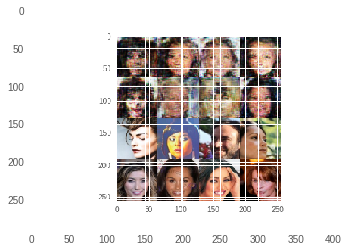


Epoch 13/400, Time: 25.223225593566895, Discriminator loss:1.0293212,Generator loss:3.7873998


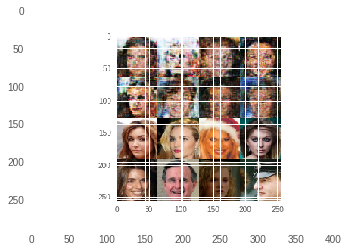


Epoch 14/400, Time: 25.331424474716187, Discriminator loss:0.82223856,Generator loss:3.1992354


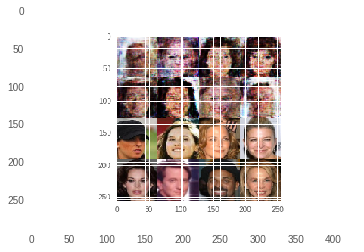


Epoch 15/400, Time: 25.25481367111206, Discriminator loss:0.78781253,Generator loss:2.8207128


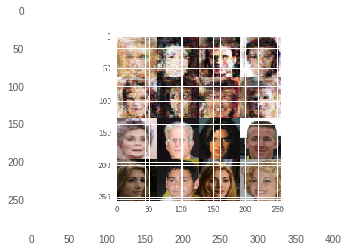


Epoch 16/400, Time: 25.31000280380249, Discriminator loss:0.8535856,Generator loss:2.2026958


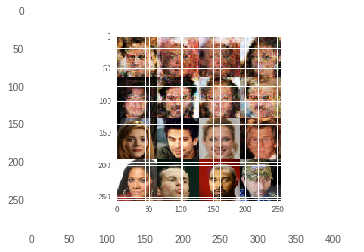


Epoch 17/400, Time: 25.25325846672058, Discriminator loss:0.8269907,Generator loss:2.9961255


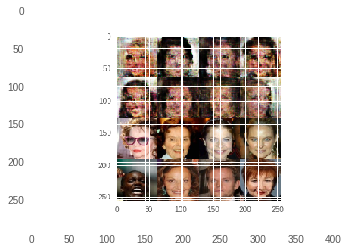


Epoch 18/400, Time: 25.30923628807068, Discriminator loss:0.76943386,Generator loss:3.914214


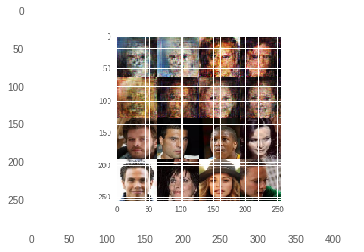


Epoch 19/400, Time: 25.36517882347107, Discriminator loss:0.82606065,Generator loss:2.5469344


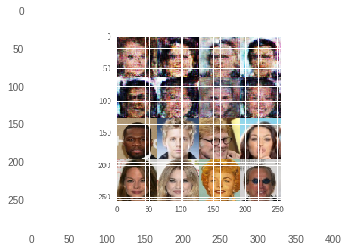


Epoch 20/400, Time: 25.32357382774353, Discriminator loss:0.7990057,Generator loss:2.5615983


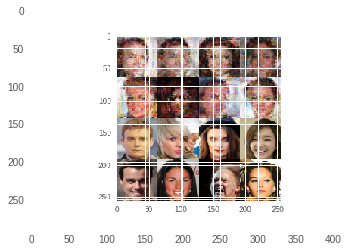


Epoch 21/400, Time: 25.312283039093018, Discriminator loss:0.8013547,Generator loss:3.0586834


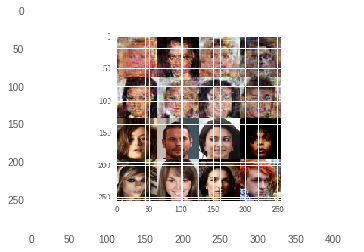


Epoch 22/400, Time: 25.338183641433716, Discriminator loss:0.7587957,Generator loss:3.9015074


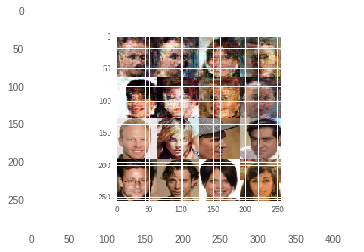


Epoch 23/400, Time: 25.365501165390015, Discriminator loss:0.77903545,Generator loss:3.2634192


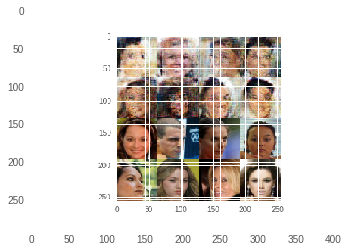


Epoch 24/400, Time: 25.326162815093994, Discriminator loss:0.9066271,Generator loss:3.8226566


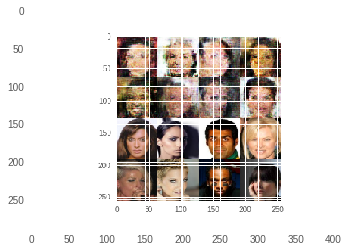


Epoch 25/400, Time: 25.39521360397339, Discriminator loss:0.8010269,Generator loss:3.1089244


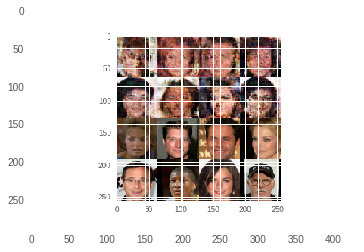


Epoch 26/400, Time: 25.410288333892822, Discriminator loss:0.79473495,Generator loss:2.7429566


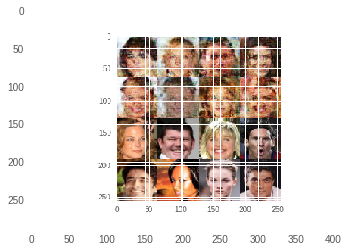


Epoch 27/400, Time: 25.399619340896606, Discriminator loss:0.76495045,Generator loss:2.4937086


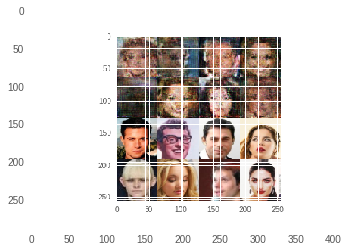


Epoch 28/400, Time: 25.378342390060425, Discriminator loss:0.79338694,Generator loss:3.0800855


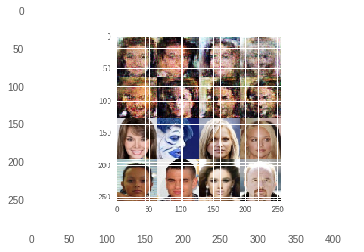


Epoch 29/400, Time: 25.349478721618652, Discriminator loss:0.77793634,Generator loss:3.2385254


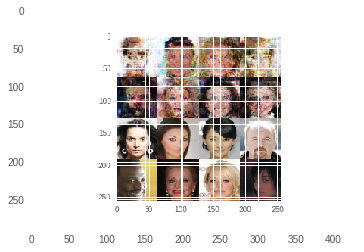

KeyboardInterrupt: ignored

In [61]:
os.environ["KERAS_BACKEND"] = "tensorflow" #Set backend to tensorflow
image_data_format = "channels_last" #Setting image data format for tensorflow
K.set_image_data_format(image_data_format)    
# Launch training
train_GAN(batch_size,n_batch_per_epoch,nb_epoch,generator,model_name,image_data_format,img_dim,bn_mode,label_smoothing,label_flipping,noise_scale,dset,use_mbd,epoch)

# Display final generated images

In [59]:
#Display final image
%matplotlib inline #Change with pylab
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import ndimage, misc


img=mpimg.imread('./figures/current_batch.png')

#image_resized = misc.imresize(img, (1280, 1280))

imgplot = plt.imshow(img)
plt.show()


UsageError: unrecognized arguments: #Change with pylab


In [0]:
#import os, signal
#os.kill(os.getpid(), signal.SIGKILL)